تکمیل آموزش
 دقت اولیه: 86.67
 Threshold: 0.95 | حذف‌شده‌ها: 2 | فشرده‌سازی: 3.12% | دقت: 86.60
 Threshold: 0.90 | حذف‌شده‌ها: 8 | فشرده‌سازی: 12.50% | دقت: 86.72
 Threshold: 0.85 | حذف‌شده‌ها: 17 | فشرده‌سازی: 26.56% | دقت: 86.39
 Threshold: 0.80 | حذف‌شده‌ها: 28 | فشرده‌سازی: 43.75% | دقت: 84.11
 Threshold: 0.75 | حذف‌شده‌ها: 37 | فشرده‌سازی: 57.81% | دقت: 76.79
 Threshold: 0.70 | حذف‌شده‌ها: 43 | فشرده‌سازی: 67.19% | دقت: 72.69
 Threshold: 0.65 | حذف‌شده‌ها: 46 | فشرده‌سازی: 71.88% | دقت: 37.65
 Threshold: 0.60 | حذف‌شده‌ها: 47 | فشرده‌سازی: 73.44% | دقت: 36.81
 Threshold: 0.55 | حذف‌شده‌ها: 50 | فشرده‌سازی: 78.12% | دقت: 21.67
 Threshold: 0.50 | حذف‌شده‌ها: 51 | فشرده‌سازی: 79.69% | دقت: 22.25
 Threshold: 0.40 | حذف‌شده‌ها: 53 | فشرده‌سازی: 82.81% | دقت: 10.85
 Threshold: 0.30 | حذف‌شده‌ها: 53 | فشرده‌سازی: 82.81% | دقت: 10.85
 Threshold: 0.20 | حذف‌شده‌ها: 53 | فشرده‌سازی: 82.81% | دقت: 10.85


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 Threshold: 0.10 | حذف‌شده‌ها: 53 | فشرده‌سازی: 82.81% | دقت: 10.85

 بیشترین افت دقت  threshold=0.65 | افت دقت=35.04


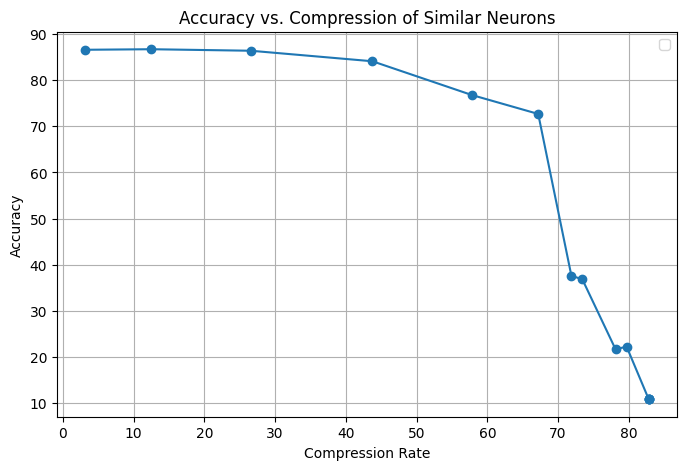

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x, return_third=False):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        if return_third:
            return x
        x = self.fc4(x)
        return x

transform = transforms.ToTensor()
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000)

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(5):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
print("تکمیل آموزش")

def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

initial_acc = evaluate(model)
print(f" دقت اولیه: {initial_acc:.2f}")

def compress_layer3_aggressive(model, threshold=0.5):
    model.eval()
    outputs_list = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images, return_third=True)
            outputs_list.append(outputs)
            if len(outputs_list) >= 3:
                break
    all_outputs = torch.cat(outputs_list, dim=0)

    num_neurons = all_outputs.shape[1]
    similarity_matrix = torch.zeros((num_neurons, num_neurons))

    for i in range(num_neurons):
        for j in range(i+1, num_neurons):
            sim = F.cosine_similarity(all_outputs[:, i], all_outputs[:, j], dim=0)
            similarity_matrix[i, j] = sim

    to_remove = set()
    for i in range(num_neurons):
        for j in range(i + 1, num_neurons):
            if similarity_matrix[i, j] > threshold:
                if j not in to_remove:
                    to_remove.add(j)

    keep_indices = [i for i in range(num_neurons) if i not in to_remove]
    pruned_model = MLP().to(device)
    pruned_model.load_state_dict(model.state_dict())

    with torch.no_grad():
        W3 = model.fc3.weight.data[keep_indices, :]
        b3 = model.fc3.bias.data[keep_indices]
        pruned_model.fc3 = nn.Linear(128, len(keep_indices)).to(device)
        pruned_model.fc3.weight.data = W3.clone()
        pruned_model.fc3.bias.data = b3.clone()

        W4 = model.fc4.weight.data[:, keep_indices]
        pruned_model.fc4 = nn.Linear(len(keep_indices), 10).to(device)
        pruned_model.fc4.weight.data = W4.clone()
        pruned_model.fc4.bias.data = model.fc4.bias.data.clone()

    removed = num_neurons - len(keep_indices)
    compression = 100 * removed / num_neurons
    return pruned_model, removed, compression

thresholds = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.4, 0.3, 0.2, 0.1]
accs = []
comps = []
drop_diffs = []

prev_acc = initial_acc
for t in thresholds:
    pruned_model, removed, compression = compress_layer3_aggressive(model, threshold=t)
    acc = evaluate(pruned_model)
    accs.append(acc)
    comps.append(compression)
    drop = prev_acc - acc
    drop_diffs.append(drop)
    prev_acc = acc
    print(f" Threshold: {t:.2f} | حذف‌شده‌ها: {removed} | فشرده‌سازی: {compression:.2f}% | دقت: {acc:.2f}")

    if compression >= 90:
        print("فشرده سازی بالای ۹۰ درصد ")
        break

max_diff = max(drop_diffs)
max_diff_index = drop_diffs.index(max_diff)
worst_threshold = thresholds[max_diff_index]
print(f"\n بیشترین افت دقت  threshold={worst_threshold:.2f} | افت دقت={max_diff:.2f}")

plt.figure(figsize=(8,5))
plt.plot(comps, accs, marker='o')
plt.xlabel("Compression Rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Compression of Similar Neurons")
plt.grid(True)
plt.legend()
plt.show()
